In [5]:
# !pip install Unidecode && pip install rasterio



In [6]:
# !pip install ee

In [2]:
#!pip install arcpy

ERROR: Could not find a version that satisfies the requirement arcpy (from versions: none)
ERROR: No matching distribution found for arcpy


In [6]:
#!pip install geopandas

In [8]:
#!pip install geemap

In [1]:
import ee
import geemap

In [2]:

import rasterio
from rasterio.plot import show

In [3]:
# Authenticate and initialize Earth Engine

!earthengine authenticate --force

#ee.Initialize()
#ee.Authenticate()

# Specify your Earth Engine project ID
project_id = 'musa650-final-sk-rg'

# Initialize Earth Engine with your project ID
ee.Initialize(project=project_id)

# Define the area of interest (AOI) as a GeoJSON polygon
aoi_coords = [
    [92.59850521269148,26.444817468598444],
    [93.10112972441023,26.444817468598444],
    [93.10112972441023,26.876818694646087],
    [92.59850521269148,26.876818694646087],
    [92.59850521269148,26.444817468598444]]

aoi = ee.Geometry.Polygon(aoi_coords)

# Define the time range
start_date = '2013-01-01'
end_date = '2023-12-31'

# Create an image collection and filter by date and location
collection = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
              .filterBounds(aoi)
              .filterDate(start_date, end_date))

# Select bands of interest
selected_bands = ['water','trees','grass','flooded_vegetation','crops','shrub_and_scrub','built','bare','snow_and_ice',	
'label']

# Iterate over each image in the collection
for image in collection.toList(collection.size()).getInfo():
    # Get the image ID
    image_id = image['id']
    
    # Clip the image to the AOI
    clipped_image = ee.Image(image_id).clip(aoi)

# Print the size of the filtered collection
print("Number of images in the filtered collection:", collection.size().getInfo())
    


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=http%3A%2F%2Flocalhost%3A8085&response_type=code&code_challenge=9NkAD1-1uxWTHS53QaiJeldgZx_9UucwVt3lVSzycO8&code_challenge_method=S256

Waiting for successful authorization from web browser ...

Successfully saved authorization token.
Number of images in the filtered collection: 966


In [56]:

# Iterate over each image in the collection
image_list = collection.toList(collection.size())
for i in range(image_list.size().getInfo()):
    # Get the image
    image = ee.Image(image_list.get(i))
    
    # Define the filename for the exported image
    image_id = image.id().getInfo()  # Get the image ID
    filename = "image_" + image_id  # Construct filename as desired
    
    # Export the image to Google Drive as GeoTIFF
    task = ee.batch.Export.image.toDrive(image=image,
                                          description=filename,
                                          folder='./data',
                                          fileNamePrefix=filename,
                                          scale=10)  # Adjust scale as needed
    task.start()

print("Export tasks started.")

Export tasks started.


In [46]:
from IPython.display import Image

In [39]:
# Get the first image in the collection
first_image = collection.first()

# Clip the first image to the AOI
clipped_image = first_image.clip(aoi)

# Get the image URL with specified bands
image_url = clipped_image.getThumbURL({
    'bands': ['water','trees','grass'],  # Specify bands for visualization
    'dimensions': 512,  # Thumbnail size
   # 'region': aoi_coords,  # Region of interest
})

# Display the image
Image(url=image_url)

In [40]:
# # Limit the collection to the first two images
# limited_collection = collection.limit(900)

# # Get the second image in the limited collection
# selected_image = limited_collection.toList(967).get(1)

# # Clip the selected image to the AOI
# clipped_image = ee.Image(selected_image).clip(aoi)

# # Get the image URL with specified bands
# image_url = clipped_image.getThumbURL({
#     'bands': ['water', 'trees', 'grass'],  # Specify bands for visualization
#     'dimensions': 512,  # Thumbnail size
#     #'region': aoi_coords,  # Region of interest
# })

# # Display the image
# Image(url=image_url)

In [41]:
# Define a function to add a metadata property with unique label names to each image
def addLabel(image):
    # Get the image ID
    image_id = image.id()
    # Add a metadata property with a unique label name
    return image.set('label', image_id)

# Apply the function to each image in the collection to add unique label names
labeled_collection = collection.map(addLabel)

# Print the first image in the collection to verify that the label property has been added
first_image = labeled_collection.first()
print("First image with label:", first_image.get('label').getInfo())

First image with label: 20151206T042142_20151206T042447_T46RDQ


In [42]:
# Extract label names from the images in the collection
label_names = labeled_collection.aggregate_array('label').getInfo()

# Print the list of label names
#print("List of label names:")
#print(label_names)

In [43]:
# Define the label of the image you want to print
specific_label = "20231229T042159_20231229T042423_T46REQ"  # Replace SPECIFIC_LABEL_ID with the desired label

# Filter the collection to get the image with the specific label
specific_image = labeled_collection.filterMetadata('label', 'equals', specific_label).first()

# Get the thumbnail URL for the specific image
specific_image_url = specific_image.getThumbUrl({
    'bands': ['water', 'trees', 'grass'],  # Specify bands for visualization
    'dimensions': 512,  # Thumbnail size
   # 'region': aoi_coords,  # Region of interest
})

# Display the specific image
Image(url=specific_image_url)


In [57]:
#!pip install pylandstats

In [58]:
import numpy as np
import os
import time
from pylandstats import Landscape

In [67]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [68]:
import rasterio
from pylandstats import Landscape

# Open the GeoTIFF file
with rasterio.open('./data/landsat_image.tif') as src:
    # Read the raster data as a numpy array
    raster_data = src.read(1)
    # Specify the resolution (in meters/pixel) of the raster data
    resolution = src.res[0]  # Assuming the resolution is the same in both x and y directions

# Create a Landscape object from the raster data
landscape = Landscape(raster_data, res=(resolution, resolution))

# Run each metric separately and measure the processing time
for metric_name in metric_names:
    start_time = time.time()
    if metric_name == "Edge Density":
        metric_value = landscape.edge_density()
    elif metric_name == "Number of Patches":
        metric_value = landscape.number_of_patches()
    elif metric_name == "Patch Density":
        metric_value = landscape.patch_density()
    elif metric_name == "Largest Patch Index":
        metric_value = landscape.largest_patch_index()
    elif metric_name == "Fractal Dimension":
        metric_value = landscape.fractal_dimension()
    elif metric_name == "Euclidean Nearest Neighbor":
        metric_value = landscape.euclidean_nearest_neighbor()
    else:
        metric_value = None

    end_time = time.time()
    processing_time = end_time - start_time

    print(f"Metric: {metric_name}")
    print(f"Value: {metric_value}")
    print(f"Processing Time: {processing_time:.4f} seconds")
    print("---------------------------")


Metric: Edge Density
Value: 73153823.73905353
Processing Time: 6.9425 seconds
---------------------------
Metric: Number of Patches
Value: 5218
Processing Time: 0.2363 seconds
---------------------------
Metric: Patch Density
Value: 2434705845901.3735
Processing Time: 0.0000 seconds
---------------------------
Metric: Largest Patch Index
Value: 0.03831417624521073
Processing Time: 0.3191 seconds
---------------------------
Metric: Fractal Dimension
Value:          class_val  fractal_dimension
0     7.262733e-08                1.0
1     7.262733e-08                1.0
2     7.262733e-08                1.0
3     7.262733e-08                1.0
4     7.262733e-08                1.0
...            ...                ...
5213  7.262733e-08                1.0
5214  7.262733e-08                1.0
5215  7.262733e-08                1.0
5216  7.262733e-08                1.0
5217  7.262733e-08                1.0

[5218 rows x 2 columns]
Processing Time: 0.6642 seconds
---------------------------

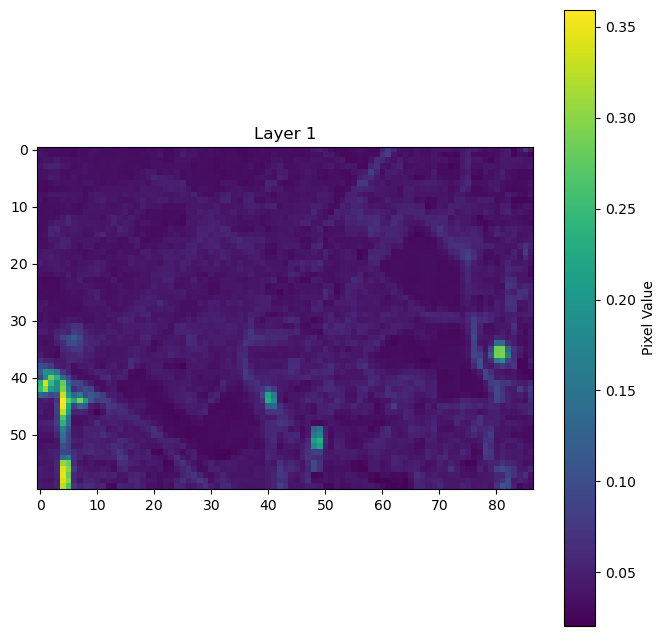

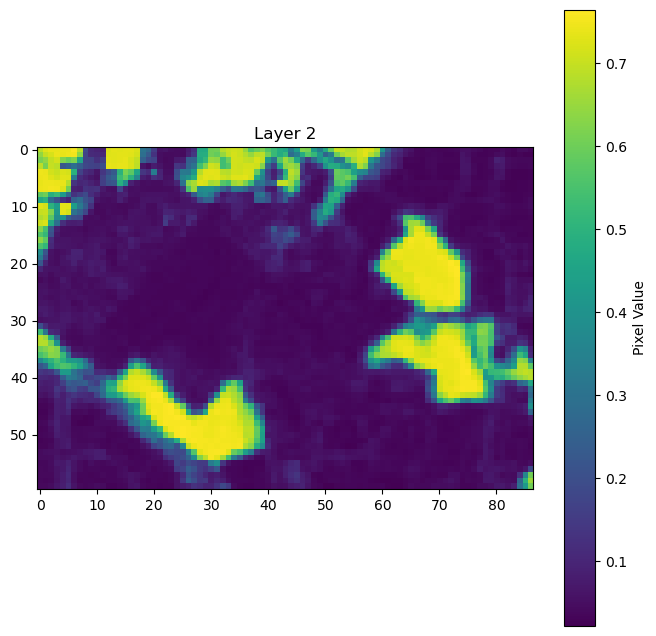

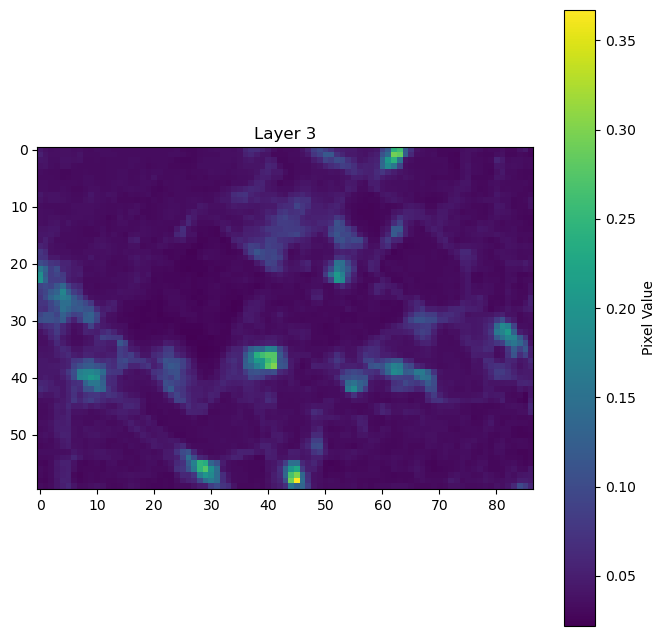

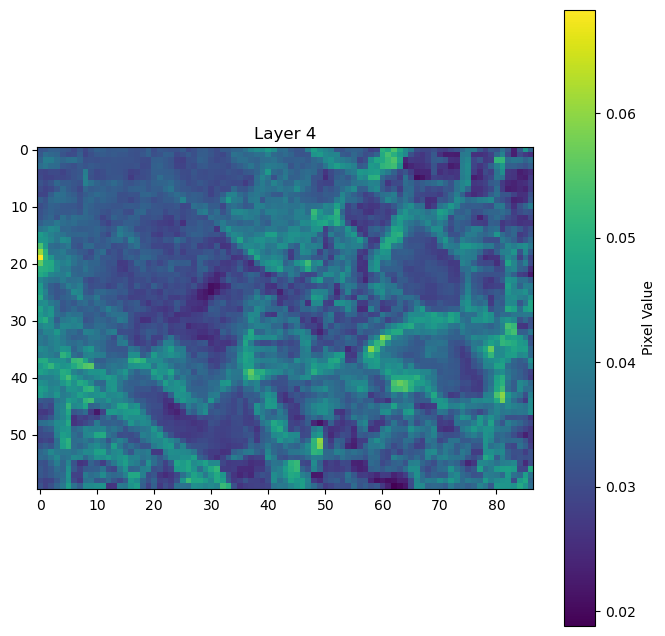

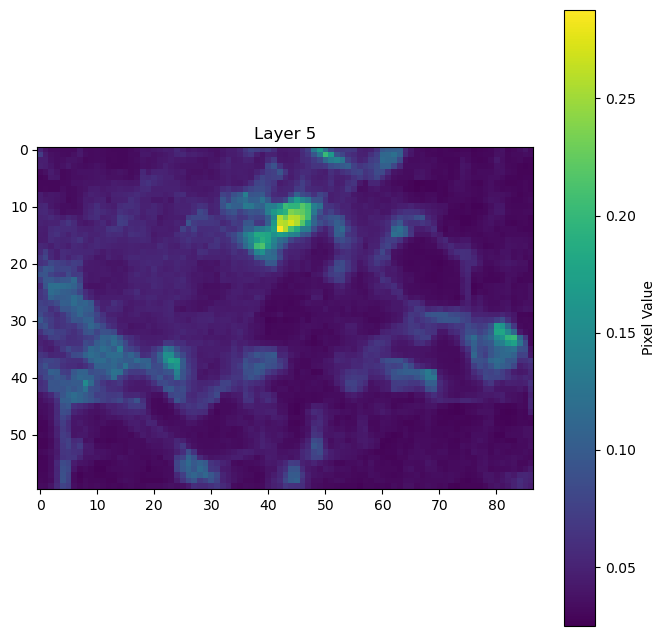

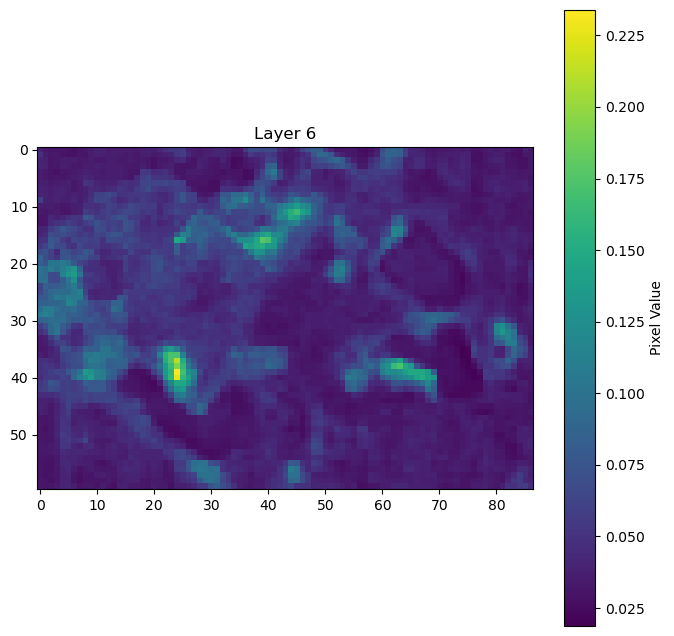

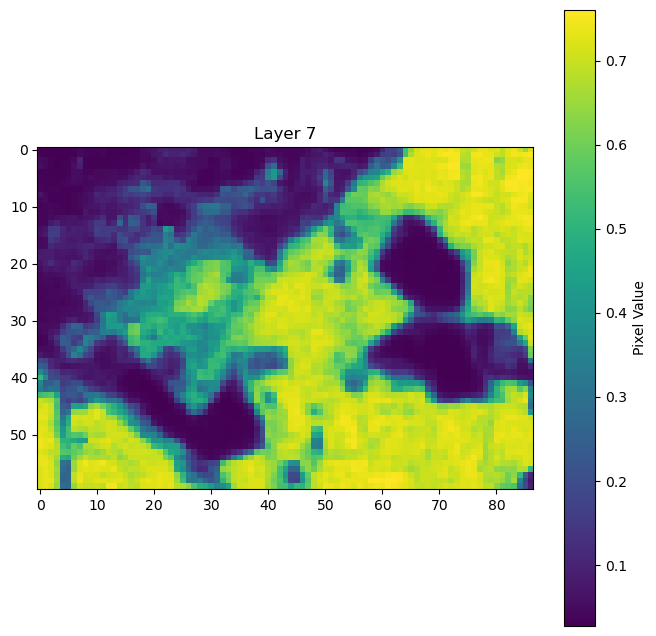

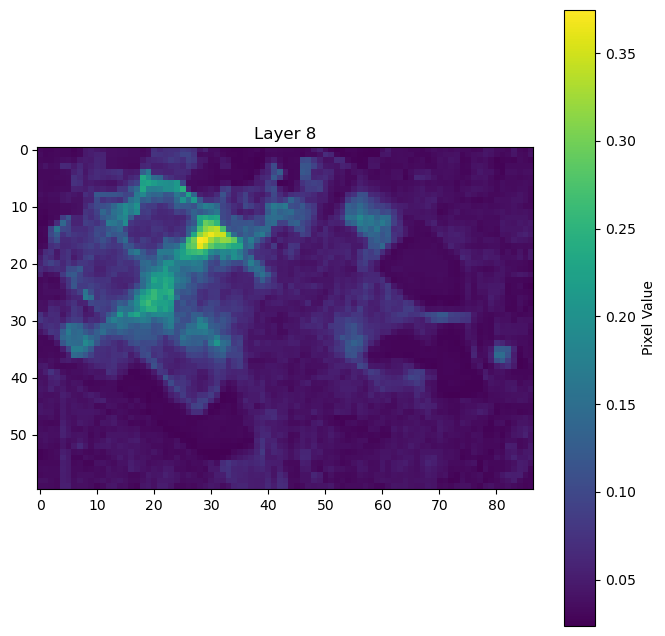

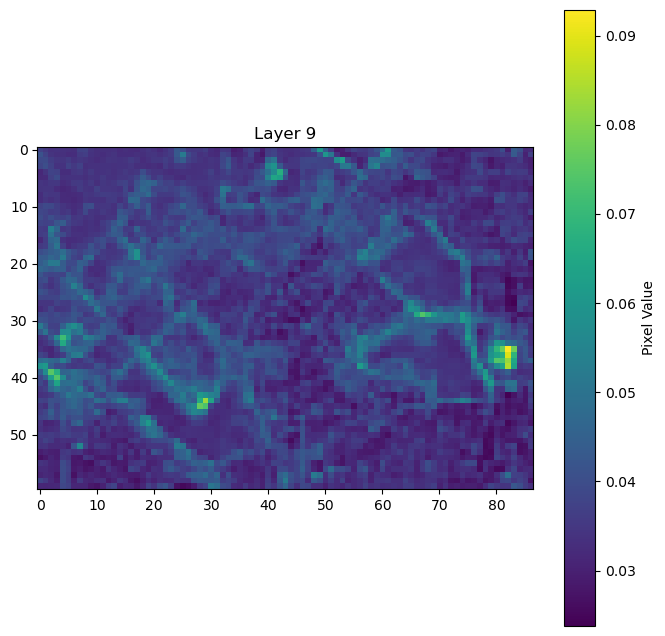

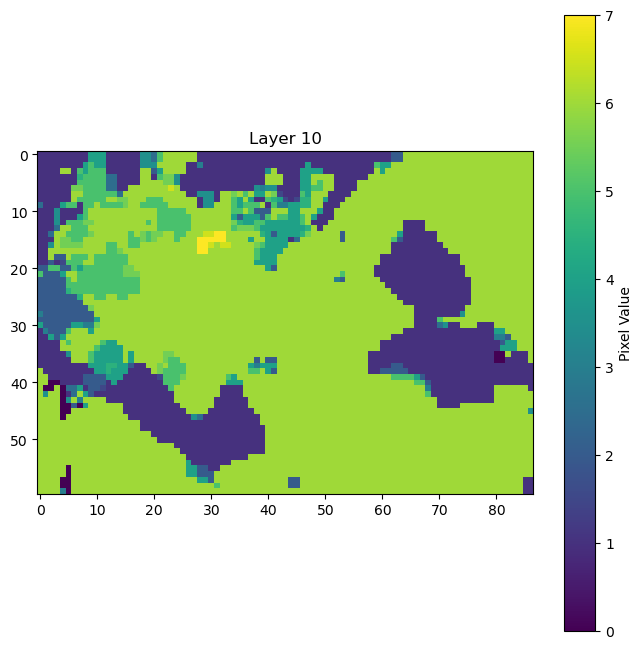

In [70]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open('./data/landsat_image.tif') as src:
    # Get the number of bands (layers) in the TIFF file
    num_bands = src.count
    
    # Iterate over each band (layer) in the TIFF file
    for i in range(1, num_bands + 1):
        # Read the band data
        band_data = src.read(i)
        
        # Visualize the band data
        plt.figure(figsize=(8, 8))
        plt.imshow(band_data, cmap='viridis')  # Use cmap='gray' for grayscale images
        plt.title(f"Layer {i}")
        plt.colorbar(label='Pixel Value')
        plt.show()


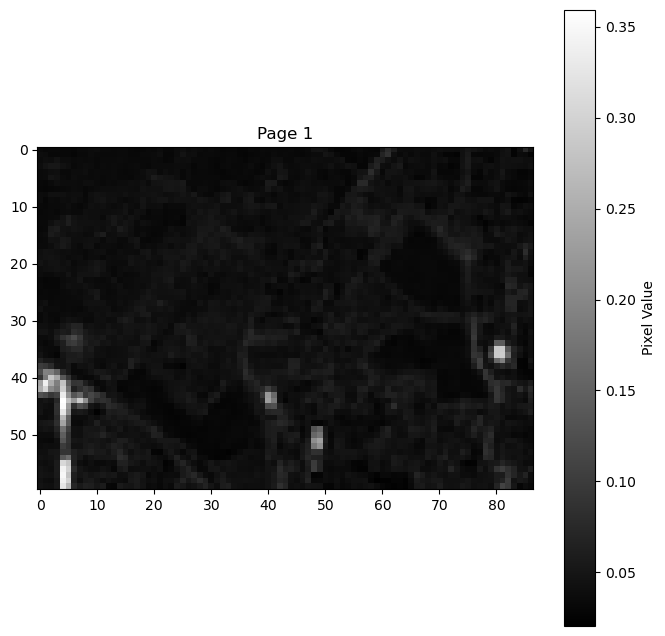

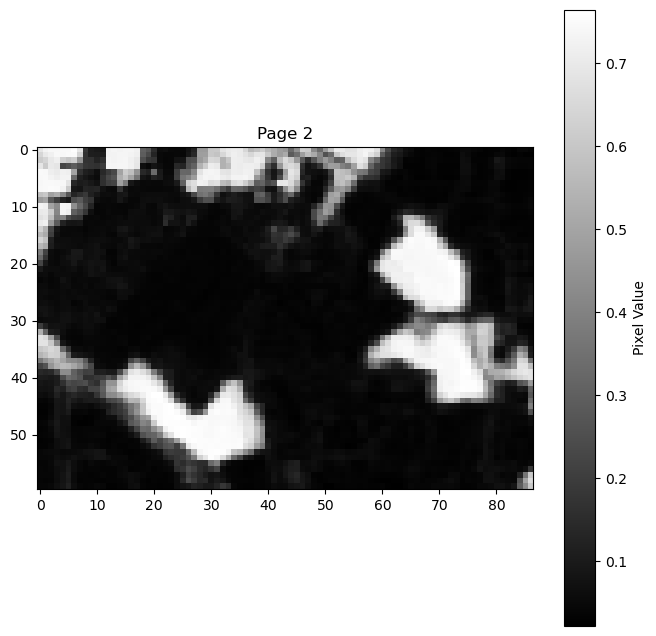

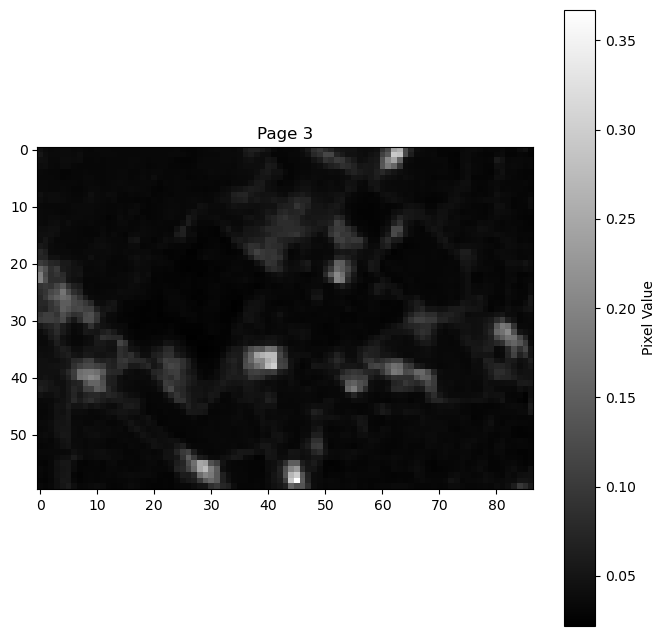

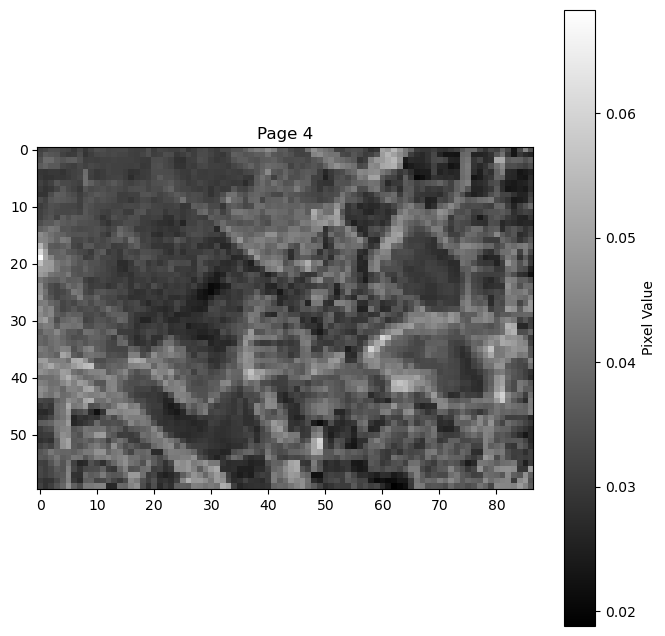

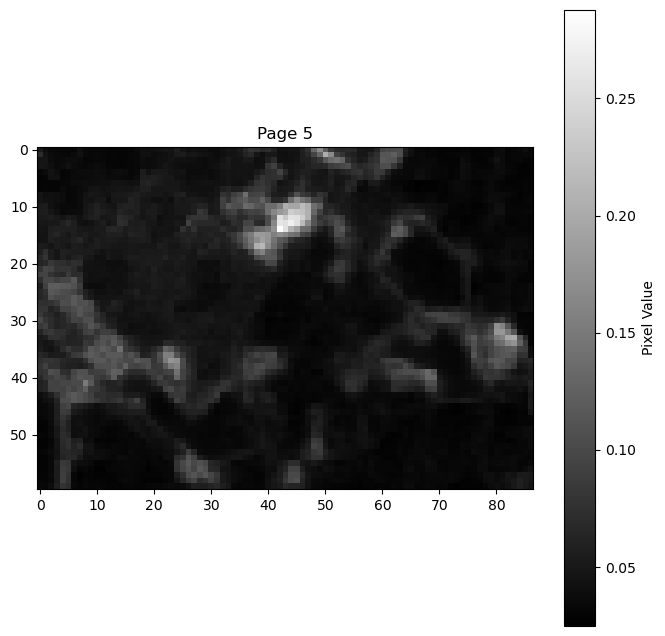

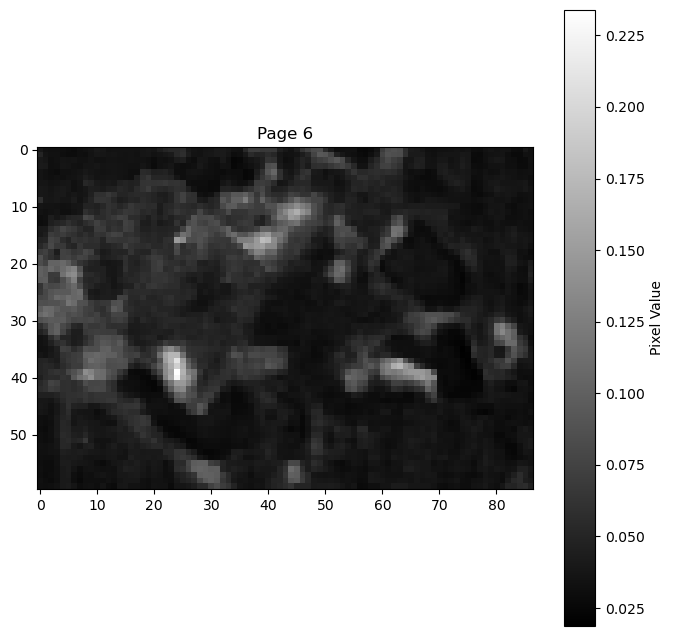

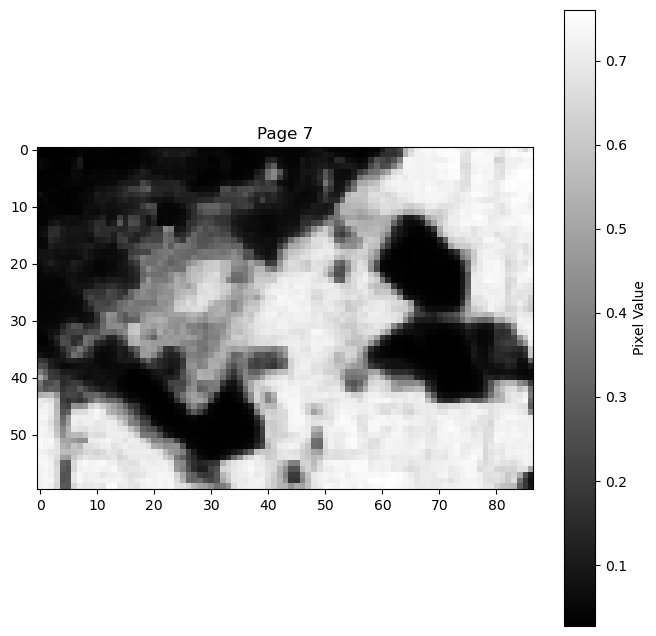

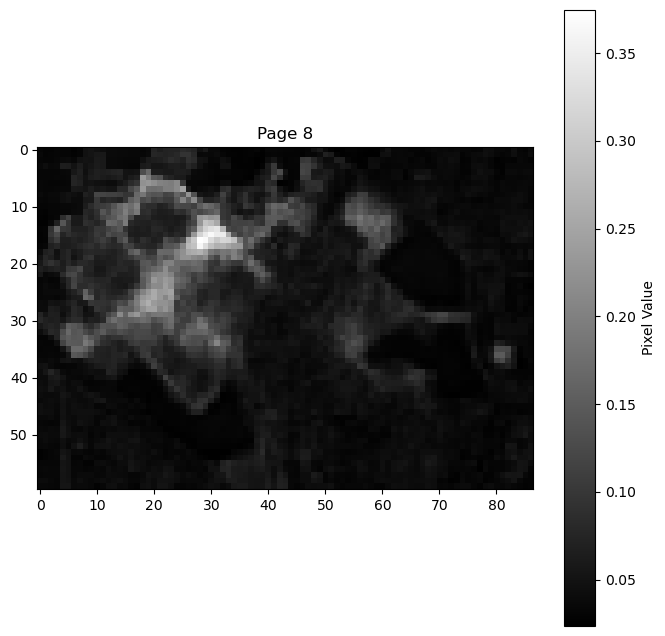

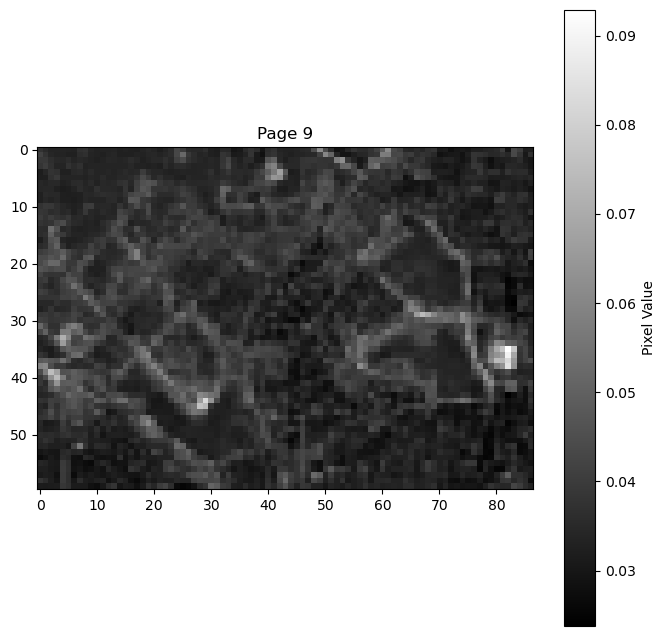

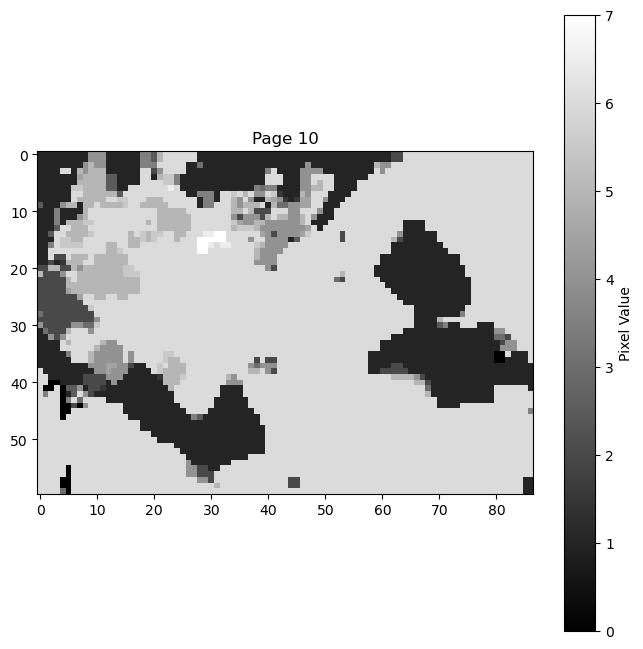

In [74]:
# Open the TIFF file
with rasterio.open('./data/landsat_image.tif') as src:
    # Iterate over the first 10 pages (directories) in the TIFF file
    for i in range(min(10, src.count)):
        # Read the data from the current page
        page_data = src.read(i + 1)
        
        # Visualize the page data
        plt.figure(figsize=(8, 8))
        plt.imshow(page_data, cmap='gray')  # Use cmap='gray' for grayscale images
        plt.title(f"Page {i + 1}")
        plt.colorbar(label='Pixel Value')
        plt.show()
